<font size="6"> **Analyze SEC 10-K Fillings** </font>

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%run ../nb_config.py

In [3]:
import numpy as np
import pandas as pd
import datetime as dt
import scipy
import pickle

import os

from tqdm import tqdm

In [4]:
from src import utils
from src.load_data import io_utils
from src.mle_quant_utils import quant_factors

In [5]:
cfg = utils.read_conf()

In [6]:
INPATH1 = os.path.join(io_utils.interim_path, 'sec_fillings', '')
INPATH2 = os.path.join(io_utils.raw_path, 'market_data', cfg['quantopian']['dataset4']['folder'],'')
INPATH3 = os.path.join(io_utils.processed_path, 'sec_fillings', '')
os.path.isdir(INPATH1), os.path.isdir(INPATH2), os.path.isdir(INPATH3)

(True, True, True)

In [7]:
INFILE1 = 'metadata.pkl'
INFILE2 =  'parsed_sentiment_loughran_mcdonald.csv'
INFILE3 = cfg['quantopian']['dataset4']['prices']
INFILE4 = cfg['output']['interim']['pricing']
INFILE5 = cfg['output']['interim']['sector_factors']
INFILE6 = 'sec_10k_loughran_sent_alpha.csv'
INFILE7 = 'sec_10k_mlbow_sent_alpha.csv'

In [8]:
OUTPATH =  os.path.join(io_utils.processed_path, 'sec_fillings', '')
os.path.isdir(OUTPATH)

True

In [9]:
START_DT = '1998-01-01'
END_DT = '2017-12-31'
train_test_split_yr = '2013-12-31'

# Load Data

## Sentiments Metadata

In [10]:
sentiment_df =  pd.read_csv(INPATH1 + INFILE2)
sentiments = sentiment_df.columns.tolist()[:-1]
sentiments

['negative',
 'positive',
 'uncertainty',
 'litigious',
 'constraining',
 'interesting']

## Prices

In [11]:
# Yearly pricing
pricing_yr = pd.read_csv(INPATH2 + INFILE3, parse_dates=['date'])
pricing_yr = pricing_yr.pivot(index='date', columns='ticker', values='adj_close')[START_DT:]
pricing_yr.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 21 entries, 1998-01-01 to 2018-01-01
Columns: 11941 entries, A to ZZZ
dtypes: float64(11941)
memory usage: 1.9 MB


In [12]:
pd.concat([pricing_yr.head(2), pricing_yr.tail(2)], axis=0)

ticker,A,AA,AAAP,AABA,AAC,AADR,AAIT,AAL,AAMC,AAME,AAN,AAOI,AAON,AAP,AAPC,AAPL,AAT,AAU,AAV,AAVL,AAWW,AAXJ,AAXN,AA_P_B,AA_W,...,ZOES,ZOM,ZOOM,ZPIN,ZQK,ZROZ,ZS,ZSAN,ZSL,ZSML,ZSPH,ZTO,ZTR,ZTS,ZU,ZUMZ,ZUO,ZVZZC,ZVZZCNX,ZX,ZXYZ_A,ZYME,ZYNE,ZZK,ZZZ
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1998-01-01,NaN,NaN,NaN,29.6125,NaN,NaN,NaN,NaN,NaN,4.543018,4.199306,NaN,0.701835,NaN,NaN,1.300324,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,4.00,NaN,5.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.714852,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1999-01-01,52.378553,NaN,NaN,108.1750,NaN,NaN,NaN,NaN,NaN,2.155487,5.142459,NaN,1.083688,NaN,NaN,3.265419,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,8.44,NaN,3.875,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.671104,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-01,66.653918,53.87,81.62,69.8500,9.00,58.835707,NaN,51.803585,81.6,3.378882,39.797356,37.82,36.522919,99.593649,10.6,167.901180,37.654925,1.03,4.3,NaN,58.65,75.858764,26.50,NaN,NaN,...,16.72,1.9771,NaN,18.2,NaN,120.593382,NaN,10.40,31.40,26.9,NaN,15.641173,12.643875,71.815333,NaN,20.825,NaN,100.1,NaN,1.2165,NaN,7.5931,12.52,25.0,0.01
2018-01-01,61.800000,46.88,81.63,73.3500,9.81,52.880000,NaN,37.990000,67.9,2.575000,43.740000,46.00,35.250000,135.860000,NaN,185.400000,38.860000,0.71,3.1,NaN,71.45,70.250000,64.98,NaN,NaN,...,10.16,2.2100,NaN,NaN,NaN,115.750000,36.67,4.68,34.91,NaN,NaN,19.450000,11.450000,86.150000,NaN,24.300,26.74,NaN,NaN,1.3800,NaN,15.3400,9.17,NaN,NaN


In [13]:
# Daily pricing
pricing = pd.read_csv(io_utils.interim_path + INFILE4, parse_dates=['date'], index_col='date')

pd.concat([pricing.head(2), pricing.tail(2)], axis=0)

,A,AAL,AAP,AAPL,ABBV,ABC,ABT,ACN,ADBE,ADI,ADM,ADP,ADS,ADSK,AEE,AEP,AES,AET,AFL,AGN,AIG,AIV,AIZ,AJG,AKAM,...,WBA,WDC,WEC,WFC,WHR,WM,WMB,WMT,WRK,WU,WY,WYN,WYNN,XEC,XEL,XL,XLNX,XOM,XRAY,XRX,XYL,YUM,ZBH,ZION,ZTS
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2011-01-06,57.014,10.822,59.209,42.399,NaN,31.088,19.926,41.270,32.27,30.936,26.230,34.990,70.301,41.26,20.703,26.659,10.986,29.308,23.236,50.648,46.749,20.247,32.972,22.599,48.45,...,35.023,28.571,22.424,26.328,73.779,28.636,14.060,44.446,NaN,15.490,15.583,25.603,85.930,85.815,17.834,19.045,25.095,59.697,33.386,25.945,NaN,30.184,49.601,23.427,NaN
2011-01-07,57.495,10.976,60.790,42.702,NaN,31.150,20.009,41.338,32.04,30.756,26.445,35.070,70.026,40.76,20.703,26.555,10.986,29.371,23.145,51.440,47.314,20.088,32.596,22.458,48.69,...,34.814,28.589,22.594,25.796,73.468,28.479,14.283,44.545,NaN,15.346,16.011,25.509,88.972,87.296,17.993,19.010,24.954,60.023,33.251,25.583,NaN,30.560,49.592,23.182,NaN
2016-01-04,130.838,39.933,151.537,100.621,52.526,97.613,40.544,96.984,91.97,51.310,33.183,77.587,267.230,60.31,39.633,53.390,8.493,106.357,27.897,300.779,57.212,36.450,74.077,37.451,52.31,...,79.032,56.158,47.153,49.176,139.143,49.421,22.642,57.521,37.972,16.153,27.113,66.912,65.687,89.186,32.915,36.226,43.194,70.617,58.018,26.056,34.923,49.300,99.714,25.983,46.398
2016-01-05,131.369,39.552,150.502,98.100,52.307,99.041,40.534,97.489,92.34,50.933,33.553,77.776,269.531,60.39,40.103,53.829,8.611,107.837,27.859,302.012,57.410,37.378,75.313,37.553,52.02,...,76.958,55.916,47.659,49.157,136.146,49.610,22.720,58.887,37.947,16.089,27.177,67.441,66.929,89.761,33.247,36.302,43.836,71.218,59.201,26.005,34.913,49.177,101.790,25.701,47.124


## Sector Metadata

In [14]:
SECTOR_FOLDER = cfg['quantopian']['dataset1']['sector_folder']
SECTOR_NAMES = cfg['quantopian']['dataset1']['sector_names']

# Specify the bundle path
sector_file = os.path.join(io_utils.raw_path, 'market_data',SECTOR_FOLDER, SECTOR_NAMES)

In [15]:
sector_names = pd.read_csv(sector_file, usecols=['Sector', 'sector_id'], index_col='sector_id')
sector_names.loc[-1, 'Sector'] = 'No sector'
sector_names = sector_names.drop_duplicates()

sector_names

,Sector
sector_id,
0,Healthcare
1,Technology
2,Consumer Defensive
3,Industrials
4,Utilities
5,Financial Services
6,Real Estate
7,Communication Services
8,Consumer Cyclical


In [16]:
sector_factor_df = pd.read_csv(io_utils.interim_path + INFILE5, parse_dates=['date'], index_col=[0,1])

sector_factor_df = sector_factor_df.reset_index().merge(sector_names, how='left', left_on='sector_code', right_index=True).\
    set_index(keys=['date', 'asset'])[['sector_code', 'Sector']]
sector_factor_df.columns = ['sector_code', 'sector']

pd.concat([sector_factor_df.head(2), sector_factor_df.tail(2)], axis=0)

sector_code              sector
date       asset                                 
2013-01-03 A                0          Healthcare
           AAL              3         Industrials
2015-12-28 ZION             5  Financial Services
           ZTS              0          Healthcare

In [17]:
# Mapping from asset to sector (no date)
sector_to_asset = sector_factor_df.reset_index('asset').drop_duplicates().set_index('asset')

pd.concat([sector_to_asset.head(2), sector_to_asset.tail(2)], axis=0)

,sector_code,sector
asset,,
A,0,Healthcare
AAL,3,Industrials
HPE,1,Technology
CSRA,1,Technology


## NLP Alpha Factors

In [18]:
sent_alphas_lou = pd.read_csv(INPATH3+INFILE6, parse_dates=['date']).rename(columns={'date': 'date_filling'})

mask = sent_alphas_lou['date_filling'].between( pd.Timestamp(START_DT), pd.Timestamp(END_DT))
sent_alphas_lou = sent_alphas_lou.loc[mask].copy()

sent_alphas_lou['date'] = sent_alphas_lou['date_filling'].dt.year.apply(lambda x: dt.datetime(year=x, month=1, day=1))
date_filling = sent_alphas_lou['date_filling']
sent_alphas_lou['ticker'] = sent_alphas_lou['ticker'].str.upper()

pd.concat([sent_alphas_lou.head(2), sent_alphas_lou.tail(2)], axis=0)

,ticker,date_filling,negative,positive,uncertainty,litigious,constraining,interesting,date
0,AAL,2003-04-15,0.156000,-0.550589,0.523059,-0.954354,-1.624239,1.486592,2003-01-01
1,AAL,2004-02-27,0.760193,-1.006005,0.696464,-0.268571,-1.042421,1.260921,2004-01-01
8632,ZTS,2016-02-24,0.919365,-1.020223,-0.694372,-1.206424,-0.329730,0.539205,2016-01-01
8633,ZTS,2017-02-16,1.069740,-1.556336,-0.606315,-0.227851,1.324624,-0.050204,2017-01-01


In [19]:
sent_alphas_mlbow = pd.read_csv(INPATH3+INFILE7, parse_dates=['date', 'date_filling'])
splits = sent_alphas_mlbow.pop('split')
sent_alphas_mlbow['ticker'] = sent_alphas_mlbow['ticker'].str.upper()

sent_alphas_mlbow_20d_5d = sent_alphas_mlbow[['date_filling', 'ticker', 'sentiment_score_5d', 'sentiment_score_20d']].\
    rename(columns={'sentiment_score_5d': 'ml_bow_sentiment_5d',
                   'sentiment_score_20d': 'ml_bow_sentiment_20d'}).dropna().set_index(['date_filling', 'ticker'])

sent_alphas_mlbow = sent_alphas_mlbow[['date', 'ticker', 'sentiment_score']].rename(columns={'sentiment_score': 'ml_bow_sentiment'})
#sent_alphas_mlbow['ticker'] = sent_alphas_mlbow['ticker'].str.upper()

pd.concat([sent_alphas_mlbow.head(2), sent_alphas_mlbow.tail(2)], axis=0)

,date,ticker,ml_bow_sentiment
0,1998-01-01,ABT,-0.126626
1,1998-01-01,ADBE,0.904468
7252,2017-01-01,ZION,-1.370159
7253,2017-01-01,ZTS,0.015482


In [20]:
sent_alphas_lou.index.shape, sent_alphas_lou.index.drop_duplicates().shape

((7322,), (7322,))

In [21]:
sent_alphas_mlbow.index.shape, sent_alphas_mlbow.index.drop_duplicates().shape

((7254,), (7254,))

In [22]:
join_cols = ['date', 'ticker']
sent_alphas = sent_alphas_lou.merge(sent_alphas_mlbow, how='inner', on=join_cols)
sent_alphas['ticker'] = sent_alphas['ticker'].str.upper()
sent_alphas = sent_alphas.drop_duplicates(subset=join_cols)

sent_alphas_yr = sent_alphas.set_index(join_cols).sort_index()  # duplicated index entries are generated
sent_alphas = sent_alphas.set_index(['date_filling', 'ticker']).sort_index()

In [23]:
# loughan and ml-bow (1yr return targets) indexed at date_Filling (match with pricing)
pd.concat([sent_alphas.head(2), sent_alphas.tail(2)], axis=0)

,,negative,positive,uncertainty,litigious,constraining,interesting,date,ml_bow_sentiment
date_filling,ticker,,,,,,,,
1998-01-21,ROP,0.202734,-0.255622,0.590575,0.044073,-1.278109,0.520066,1998-01-01,1.103451
1998-01-23,AMAT,1.189962,-1.683578,1.242852,1.630689,1.260480,-1.331016,1998-01-01,-0.180894
2017-12-21,A,0.567696,-0.822580,-0.251022,0.544525,-0.668105,-1.602679,2017-01-01,-1.207598
2017-12-22,COO,-1.185596,0.482735,1.054292,-0.598591,-0.119718,0.583143,2017-01-01,0.510907


In [24]:
# loughan and ml-bow (1yr return targets) indexed at yearly freq (match with pricing_yr)
pd.concat([sent_alphas_yr.head(2), sent_alphas_yr.tail(2)], axis=0)

date_filling  negative  positive  uncertainty  litigious  \
date       ticker                                                            
1998-01-01 ABT      1998-03-09  1.630689 -1.701207     1.295739   0.837381   
           ADBE     1998-02-17 -0.943155 -0.943156    -0.643462   0.572945   
2017-01-01 ZION     2017-02-28  0.057928  1.247386     0.490458  -0.490458   
           ZTS      2017-02-16  1.069740 -1.556336    -0.606315  -0.227851   

                   constraining  interesting  ml_bow_sentiment  
date       ticker                                               
1998-01-01 ABT         1.507287    -1.701232         -0.126626  
           ADBE       -1.137076    -0.590583          0.904468  
2017-01-01 ZION        0.003862    -1.455928         -1.370159  
           ZTS         1.324624    -0.050204          0.015482

In [25]:
# ml-bow (20d and 5d return targets) indexed at date_filling (match with pricing)
pd.concat([sent_alphas_mlbow_20d_5d.head(2), sent_alphas_mlbow_20d_5d.tail(2)], axis=0)

ml_bow_sentiment_5d  ml_bow_sentiment_20d
date_filling ticker                                           
2011-12-16   A                  0.622294              0.622294
2011-02-16   AAL               -1.136724             -1.136724
2015-02-27   ZION               0.695164              0.695164
             ZTS               -0.492082             -0.492082

In [26]:
sent_alphas.index.shape, sent_alphas.index.drop_duplicates().shape

((7242,), (7242,))

# Create Alpha Factors

Clean and Compute Forward Returns

In [27]:
import alphalens as al

In [28]:
alpha_factors = sentiments + ['ml_bow_sentiment']

## Forward Returns

In [29]:
p0, p1 = pricing.loc['2011-01-28', 'AMZN'], pricing.shift(-20).loc['2011-01-28', 'AMZN']
ret = (p1-p0) /p0 
print(p0, p1, ret)

171.14 173.29 0.012562814070351792


In [30]:
#np.isclose(ret, fwd_rets_2011.xs(key='AMZN', level='asset')['20D'])

In [31]:
factor_data_yr, factor_data_5d, factor_data_20d = {}, {}, {}
skipped_sentiments = []

for alpha in alpha_factors:
    try:
        data_yr = al.utils.get_clean_factor_and_forward_returns(
            sent_alphas_yr[alpha], pricing_yr, quantiles=5, bins=None, periods=[1])
        
        data_5d = al.utils.get_clean_factor_and_forward_returns(
            sent_alphas[alpha], pricing, quantiles=5, bins=None, periods=[5],
            max_loss=0.9)  #max loss is increase due to factor sparsity
            
        data_20d = al.utils.get_clean_factor_and_forward_returns(
            sent_alphas[alpha], pricing, quantiles=5, bins=None, periods=[20],
            max_loss=0.9  #max loss is increase due to factor sparsity
        )
        factor_data_yr[alpha] = data_yr
        factor_data_5d[alpha] = data_5d
        factor_data_20d[alpha] = data_20d
    except:
        skipped_sentiments.append(alpha)

if skipped_sentiments:
    print('\nSkipped the following sentiments:\n{}'.format('\n'.join(skipped_sentiments)))

Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 73.7% entries from factor data: 70.4% in forward returns computation and 3.3% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 90.0%, not exceeded: OK!
Dropped 73.8% entries from factor data: 70.5% in forward returns computation and 3.2% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 90.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 73.7% entries from factor data: 70.4% in forward returns computation and 3.3% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 90.0%, not exceeded: OK!
Dropped 7

In [32]:
factor_data_yr['positive'].head(2)

1D    factor  factor_quantile
date       asset                                     
1998-01-01 ABT   -0.254036 -1.701207                1
           ADBE   1.883467 -0.943156                2

In [33]:
factor_data_5d['positive'].head(2)

5D    factor  factor_quantile
date       asset                                     
2011-01-27 ADBE  -0.009453 -0.198185              5.0
           MKC   -0.010637 -1.560705              1.0

In [34]:
factor_data_20d['positive'].head(2)

20D    factor  factor_quantile
date       asset                                     
2011-01-27 ADBE   0.023043 -0.198185              5.0
           MKC    0.048507 -1.560705              1.0

In [35]:
factor_data_tgt5d_20d = {}
skipped_sentiments = []

for alpha, tau in zip(sent_alphas_mlbow_20d_5d.columns, [5, 20]):

    try:
        data_tgt5d_20d = al.utils.get_clean_factor_and_forward_returns(
            sent_alphas_mlbow_20d_5d[alpha], pricing, quantiles=5, bins=None, periods=[tau],
            max_loss=0.35)  #max loss is increase due to factor sparsity
            
        factor_data_tgt5d_20d[alpha] = data_tgt5d_20d
    except:
        skipped_sentiments.append(alpha)

if skipped_sentiments:
    print('\nSkipped the following sentiments:\n{}'.format('\n'.join(skipped_sentiments)))

Dropped 11.1% entries from factor data: 0.0% in forward returns computation and 11.1% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 11.3% entries from factor data: 0.4% in forward returns computation and 10.9% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!


In [36]:
factor_data_tgt5d_20d['ml_bow_sentiment_5d'].head(2)

,,5D,factor,factor_quantile
date,asset,,,
2011-12-16,A,0.041699,0.622294,1.0
2011-02-16,AAL,-0.165364,-1.136724,1.0


In [37]:
factor_data_tgt5d_20d['ml_bow_sentiment_20d'].head(2)

,,20D,factor,factor_quantile
date,asset,,,
2011-12-16,A,0.057036,0.622294,1.0
2011-02-16,AAL,-0.159399,-1.136724,1.0


## Alpha Factors Assessment

In [38]:
train_test_split_yr

'2013-12-31'

In [39]:
def split_factor_data_dictionary(factor_data, train_test_split_yr):
    
    last_train = pd.Timestamp(train_test_split_yr)
    first_test = last_train + pd.tseries.offsets.DateOffset(days=1)
    
    factor_data_train, factor_data_test = {}, {}
    for key_sent, val_frets in factor_data.items():
        factor_data_cp = factor_data[key_sent].sort_index()
        factor_data_train[key_sent] = factor_data_cp.loc[:last_train]
        factor_data_test[key_sent] =  factor_data_cp.loc[first_test:]
    return factor_data_train, factor_data_test

In [40]:
# loughan and ml-bow (1yr return targets) indexed at yearly freq (match with pricing_yr)
factor_data_yr_train, factor_data_yr_test = split_factor_data_dictionary(factor_data_yr, train_test_split_yr)

# loughan and ml-bow (1yr return targets) indexed at date_filling (match with pricing)
factor_data_5d_train, factor_data_5d_test = split_factor_data_dictionary(factor_data_5d, train_test_split_yr)
factor_data_20d_train, factor_data_20d_test = split_factor_data_dictionary(factor_data_20d, train_test_split_yr)

# ml-bow (20d and 5d return targets) indexed at date_filling (match with pricing)
factor_data_tgt5d_20d_train, factor_data_tgt5d_20d_test = split_factor_data_dictionary(factor_data_tgt5d_20d, train_test_split_yr)

In [41]:
factor_data_yr_train['positive'].shape

(5472, 3)

In [42]:
factor_data_yr_test['positive'].shape

(1770, 3)

In [43]:
factor_data_tgt5d_20d_test.keys()

dict_keys(['ml_bow_sentiment_20d', 'ml_bow_sentiment_5d'])

In [44]:
%%capture
# loughan and ml-bow (1yr return targets) indexed at yearly freq (match with pricing_yr)
df_factor_return_yr, df_sharpe_yr, df_rank_ic_yr, df_fra_yr, df_qr_yr = quant_factors.factor_evaluation(
    factor_data_yr, factor_names=alpha_factors, frequency="yearly")

df_factor_return_yr_train, df_sharpe_yr_train, df_rank_ic_yr_train, df_fra_yr_train, df_qr_yr_train = quant_factors.factor_evaluation(
    factor_data_yr_train, factor_names=alpha_factors, frequency="yearly")

df_factor_return_yr_test, df_sharpe_yr_test, df_rank_ic_yr_test, df_fra_yr_test, df_qr_yr_test = quant_factors.factor_evaluation(
    factor_data_yr_test, factor_names=alpha_factors, frequency="yearly")


# loughan and ml-bow (1yr return targets) indexed at date_Filling (match with pricing)
df_factor_return_5d, df_sharpe_5d, df_rank_ic_5d, df_fra_5d, df_qr_5d = quant_factors.factor_evaluation(
    factor_data_5d_test, factor_names=alpha_factors, frequency="daily")

df_factor_return_20d, df_sharpe_20d, df_rank_ic_20d, df_fra_20d, df_qr_20d = quant_factors.factor_evaluation(
    factor_data_20d_test, factor_names=alpha_factors, frequency="daily")

# ml-bow (20d and 5d return targets) indexed at date_filling (match with pricing)
df_factor_return_tgt5d_20d, df_sharpe_tgt5d_20d, df_rank_ic_tgt5d_20d, df_fra_tgt5d_20d, df_qr_tgt5d_20d = quant_factors.factor_evaluation(
    factor_data_tgt5d_20d_test, factor_names=['ml_bow_sentiment_5d', 'ml_bow_sentiment_20d'], frequency="daily")

In [47]:
df_factor_return_tgt5d_20d.columns

Index(['ml_bow_sentiment_5d', 'ml_bow_sentiment_20d'], dtype='object')

In [52]:
def compute_sharpe_ratio(returns, ann_factor=252):
    return  np.sqrt(ann_factor) * returns.mean(axis=0) / returns.std(axis=0)

In [61]:
df_sharpe_yr = compute_sharpe_ratio(df_factor_return_yr, ann_factor=1)
df_sharpe_yr_test = compute_sharpe_ratio(df_factor_return_yr_test, ann_factor=1)

df_sharpe_5d = compute_sharpe_ratio(df_factor_return_5d, ann_factor=52)
df_sharpe_20d = compute_sharpe_ratio(df_factor_return_20d, ann_factor=12)

df_sharpe_tgt5d_20d = compute_sharpe_ratio(
    df_factor_return_tgt5d_20d,
    ann_factor=pd.Series(index=['ml_bow_sentiment_5d', 'ml_bow_sentiment_20d'], data=[52, 12])
)

In [63]:
df_sharpe_yr

negative           -0.262514
positive            0.365283
uncertainty        -0.026507
litigious          -0.208861
constraining       -0.308013
interesting         0.126408
ml_bow_sentiment    1.007877
dtype: float64

In [64]:
df_sharpe_yr_test

negative           -2.739798
positive            2.052068
uncertainty         2.942257
litigious          -0.497474
constraining        1.982728
interesting        -0.116877
ml_bow_sentiment    0.489141
dtype: float64

In [65]:
df_sharpe_5d

negative            1.110229
positive            0.450325
uncertainty        -0.056374
litigious          -0.188798
constraining        0.446316
interesting        -1.379428
ml_bow_sentiment   -0.444983
dtype: float64

In [66]:
df_sharpe_20d

negative            0.377943
positive           -0.418418
uncertainty         0.036083
litigious           0.321711
constraining        0.430720
interesting        -0.513233
ml_bow_sentiment    0.515896
dtype: float64

In [67]:
df_sharpe_tgt5d_20d

ml_bow_sentiment_5d     0.070196
ml_bow_sentiment_20d   -0.673950
dtype: float64

## Sharpe Ratio

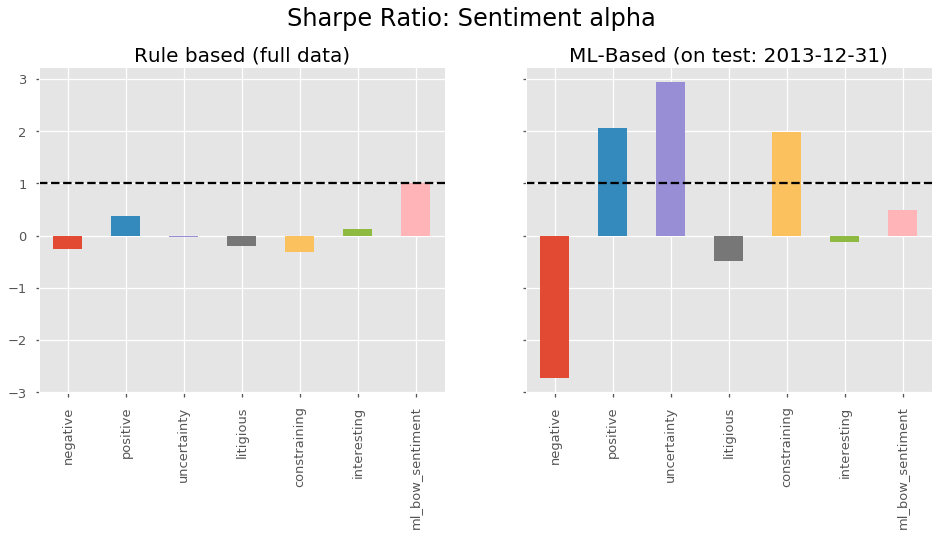

In [72]:
fig, axs = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

plt.suptitle("Sharpe Ratio: Sentiment alpha", y=1.02)
ax1 = axs[0]
df_sharpe_yr.plot.bar(ax=ax1)
ax1.set_title('Rule based (full data)')
ax1.axhline(y=1, linestyle='--', color='black')

ax2 = axs[1]
df_sharpe_yr_test.plot.bar(ax=ax2)
ax2.set_title('ML-Based (on test: {})'.format(train_test_split_yr))
ax2.axhline(y=1, linestyle='--', color='black')
#ax1.set_xticks(rotation=0)
plt.show()

## Forward Returns

In [75]:
df_sharpe_yr_test

negative           -2.739798
positive            2.052068
uncertainty         2.942257
litigious          -0.497474
constraining        1.982728
interesting        -0.116877
ml_bow_sentiment    0.489141
dtype: float64

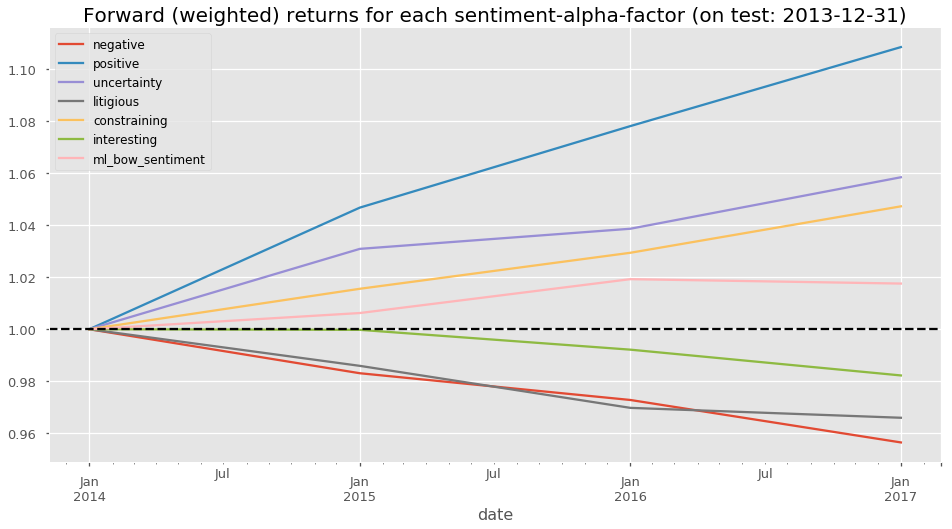

In [77]:
fwd_rets_yr = (1 + df_factor_return_yr_test).cumprod()
fwd_rets_yr.iloc[0] = 1
fwd_rets_yr.plot( figsize=(16,8))
plt.title('Forward (weighted) returns for each sentiment-alpha-factor (on test: {})'.format(train_test_split_yr))
plt.axhline(y=1, linestyle='--', color='black', )
plt.show()

## Information Coefficient

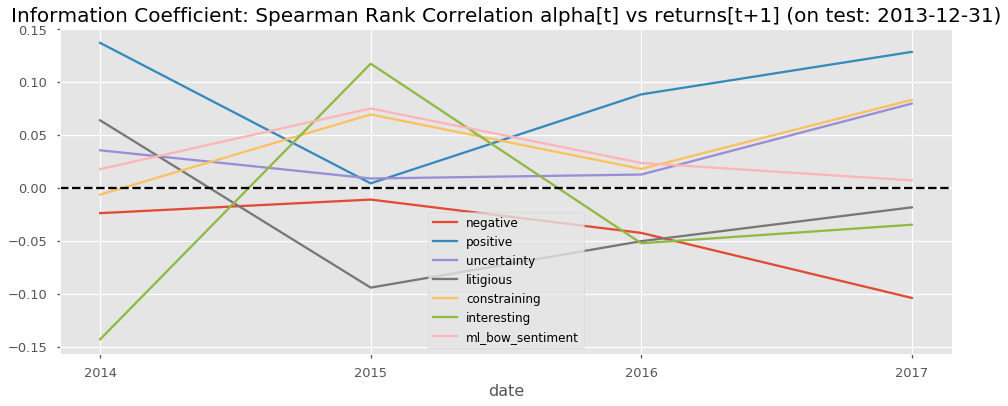

In [85]:
df_rank_ic_yr_test.plot(figsize=(16, 6))
plt.title('Information Coefficient: Spearman Rank Correlation alpha[t] vs returns[t+1] (on test: {})'.format(train_test_split_yr))
plt.axhline(y=0, linestyle='--', color='black', )
plt.show()

In [80]:
df_rank_ic_yr_test.mean(axis=0)

negative           -0.045274
positive            0.089712
uncertainty         0.034298
litigious          -0.024697
constraining        0.041143
interesting        -0.028137
ml_bow_sentiment    0.030957
dtype: float64

## Quantile Analysis

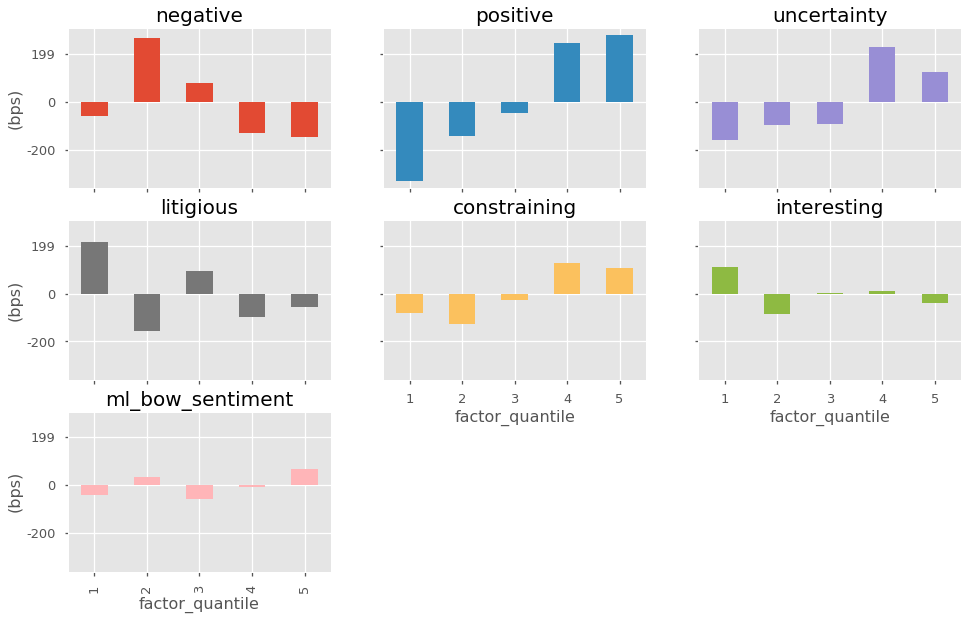

In [86]:
axs = df_qr_yr_test.plot.bar(subplots=True, layout=(3,3), legend=False, sharex=True, sharey=True,  figsize=(16, 10))
plt.title('Quantile Analysis: Forward Returns Average by sentiment-alpha-factor quantile (on test: {})'.format(train_test_split_yr))

for ax in axs[1,:]:
    ax.tick_params(labelrotation=0)
for ax in axs[:,0]:
    ax.set_yticklabels([int(x) for x in ax.get_yticks()*1e4])
    ax.set_ylabel("(bps)")
plt.show()

## Turnover (FRA)

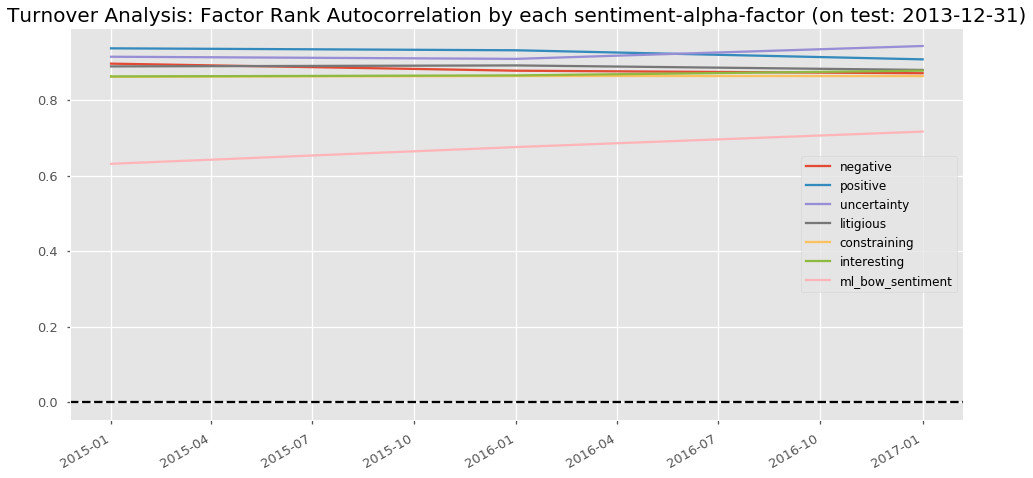

In [87]:
df_fra_yr_test.plot(title="Factor Rank Autocorrelation", figsize=(16,8))
plt.title('Turnover Analysis: Factor Rank Autocorrelation by each sentiment-alpha-factor (on test: {})'.format(train_test_split_yr))
plt.axhline(y=0, linestyle='--', color='black', )
plt.show()